In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from monty.serialization import dumpfn, loadfn
from collections import defaultdict

In [4]:
from ase.filters import FrechetCellFilter
from ase.optimize import LBFGS
from pymatgen.io.ase import AseAtomsAdaptor
from orb_models.forcefield import pretrained
from orb_models.forcefield.calculator import ORBCalculator
from fairchem.core import pretrained_mlip, FAIRChemCalculator

In [5]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [6]:
MODEL = "orb" # "orb" or "uma"

In [10]:
orb_ff = pretrained.orb_v3_conservative_inf_omat(device="cuda",precision="float32-high")   # or "float32-highest" / "float64
orb_calc = ORBCalculator(orb_ff, device="cuda")

uma_ff = pretrained_mlip.get_predict_unit("uma-m-1p1", device="cuda")
uma_calc = FAIRChemCalculator(uma_ff, task_name="omat")

MODELS = {
    "orb":orb_calc,
    "uma": uma_calc
}

/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/orb_models/utils.py:30: UserWarning: Setting global torch default dtype to torch.float32.
  warnings.warn(f"Setting global torch default dtype to {torch_dtype}.")


In [11]:
# Function used to relax initial primitive cell and for competing phase calculation, full relaxation using FrechetCellFilter
def relax_structure(structure):
    atoms = structure.to_ase_atoms()
    atoms.calc = MODELS[MODEL]

    opt = LBFGS(FrechetCellFilter(atoms)) # Delete this FrechetCellFilter when doing the defect structures
    opt.run(0.01, 1000)

    structure1 = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()

    return structure1, energy 
    

In [12]:
# Function that relaxes defect and pristine supercells, ensuring a fixed lattice by no FrechetCellFilter
def relax_defect(structure): # takes in pymatgen structure
    atoms = structure.to_ase_atoms()
    atoms.calc = MODELS[MODEL]

    opt = LBFGS(atoms) # Delete this FrechetCellFilter when doing the defect structures
    opt.run(0.01, 1000)

    structure1 = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()

    return structure1, energy 

## Relaxation of Primitive Al Cells

In [13]:
matching_pairs = loadfn('../data/matching_AlCr_ox.json')

In [14]:
relaxed_Al_prim = {}
for name, val in matching_pairs.items():
    structure, energy = relax_structure(val['structure'])
    relaxed_Al_prim[name] = {
        'formula': val['formula'],
        'energy': energy,
        'structure': structure
    }

W0728 15:04:48.450000 1535 site-packages/torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
W0728 15:04:49.208000 1535 site-packages/torch/_dynamo/convert_frame.py:1233] WON'T CONVERT forward /home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/orb_models/forcefield/gns.py line 421 
W0728 15:04:49.208000 1535 site-packages/torch/_dynamo/convert_frame.py:1233] due to: 
W0728 15:04:49.208000 1535 site-packages/torch/_dynamo/convert_frame.py:1233] Traceback (most recent call last):
W0728 15:04:49.208000 1535 site-packages/torch/_dynamo/convert_frame.py:1233]   File "/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/torch/_dynamo/convert_frame.py", line 1164, in __call__
W0728 15:04:49.208000 1535 site-packages/torch/_dynamo/convert_frame.py:1233]     result = self._inner_convert(
W0728 15:04:49.208000 1535 site-packages/torch/_dynamo/convert_frame.py:1233]              ^^^^^^^^^^^^^^^^^^^^
W0728 15:04:49.208000 1535 sit

       Step     Time          Energy          fmax
LBFGS:    0 15:04:56     -380.391235        0.811593
LBFGS:    1 15:04:56     -380.553680        0.542379


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.687423928349024e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    2 15:04:57     -380.650208        0.350434


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.803428048618954e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    3 15:04:58     -380.688293        0.312421


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.731326905817598e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    4 15:04:59     -380.715363        0.273125
LBFGS:    5 15:05:00     -380.735229        0.257167
LBFGS:    6 15:05:00     -380.750275        0.245570
LBFGS:    7 15:05:00     -380.768250        0.229827


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.686404811218285e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.669848985830407e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.675063814508864e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    8 15:05:00     -380.786224        0.202908
LBFGS:    9 15:05:00     -380.799652        0.177427
LBFGS:   10 15:05:00     -380.809662        0.158989


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.731259466637835e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.734194401254236e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.724838942184899e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.78060888021433e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   11 15:05:00     -380.821228        0.174058
LBFGS:   12 15:05:00     -380.837219        0.225091
LBFGS:   13 15:05:00     -380.856262        0.243092


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.785841948251333e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.765562489079132e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.767833413720859e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   14 15:05:00     -380.872894        0.206154
LBFGS:   15 15:05:00     -380.884888        0.192340
LBFGS:   16 15:05:00     -380.895874        0.215920


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.759813639840797e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.767906871401303e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.787896427829355e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   17 15:05:00     -380.908508        0.187522
LBFGS:   18 15:05:01     -380.919739        0.117532
LBFGS:   19 15:05:01     -380.925873        0.115813


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.824707878903057e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.823283246271467e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.774520790053465e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   20 15:05:01     -380.929382        0.097351
LBFGS:   21 15:05:01     -380.933502        0.140354
LBFGS:   22 15:05:01     -380.939056        0.154353


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.877911293946129e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.84740941025274e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.823062236030101e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   23 15:05:01     -380.946289        0.113502
LBFGS:   24 15:05:01     -380.952789        0.099627
LBFGS:   25 15:05:01     -380.957001        0.082372
LBFGS:   26 15:05:01     -380.959808        0.095887


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.814065904704323e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.884624005339496e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.798530997960736e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   27 15:05:01     -380.962341        0.085980
LBFGS:   28 15:05:01     -380.964996        0.062021


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.807664673491424e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.80863184252694e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.817812793586506e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   29 15:05:01     -380.967194        0.064448
LBFGS:   30 15:05:01     -380.968750        0.061401
LBFGS:   31 15:05:02     -380.970032        0.073922
LBFGS:   32 15:05:02     -380.971436        0.064157


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.812063613753128e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.806416067810844e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.799845911827328e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   33 15:05:02     -380.972900        0.055603
LBFGS:   34 15:05:02     -380.973907        0.033960
LBFGS:   35 15:05:02     -380.974548        0.039379


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.806758370690029e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.860135692212227e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.780181804380589e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   36 15:05:02     -380.975220        0.039924
LBFGS:   37 15:05:02     -380.976074        0.040819
LBFGS:   38 15:05:02     -380.976868        0.037567


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.860013173477596e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.882400030566045e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.895594048338565e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.865773548885104e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   39 15:05:02     -380.977325        0.024004
LBFGS:   40 15:05:02     -380.977661        0.024502
LBFGS:   41 15:05:02     -380.977997        0.028751
LBFGS:   42 15:05:02     -380.978241        0.020823


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.824745659153289e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.904393546759546e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.871804512478891e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.843524231453842e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   43 15:05:02     -380.978394        0.017319
LBFGS:   44 15:05:02     -380.978516        0.015577
LBFGS:   45 15:05:02     -380.978699        0.019333


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.812180289177229e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.853599648109625e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.831194334337988e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   46 15:05:03     -380.978851        0.018002
LBFGS:   47 15:05:03     -380.978973        0.015866
LBFGS:   48 15:05:03     -380.979065        0.016312


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.854300837315206e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.858428732334609e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.822503157983172e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   49 15:05:03     -380.979187        0.016860
LBFGS:   50 15:05:03     -380.979309        0.016766
LBFGS:   51 15:05:03     -380.979431        0.016274
LBFGS:   52 15:05:03     -380.979614        0.016035


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.862023645387855e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.843526122943055e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.85943350194007e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.868375714769045e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   53 15:05:03     -380.979736        0.019549
LBFGS:   54 15:05:03     -380.979919        0.020839
LBFGS:   55 15:05:03     -380.980072        0.016700
LBFGS:   56 15:05:03     -380.980164        0.012540


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.862941930923645e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.864841752893283e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.85271964009487e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.885949127167021e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   57 15:05:03     -380.980225        0.011988
LBFGS:   58 15:05:03     -380.980316        0.016371
LBFGS:   59 15:05:03     -380.980408        0.014262
LBFGS:   60 15:05:04     -380.980499        0.011316


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.856154643547295e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.84874229248646e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.84522108165498e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.9333254517796e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   61 15:05:04     -380.980530        0.011431
LBFGS:   62 15:05:04     -380.980560        0.010449
LBFGS:   63 15:05:04     -380.980652        0.012156


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.880402405491018e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.838014554464314e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.88193819297905e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   64 15:05:04     -380.980804        0.016498
LBFGS:   65 15:05:04     -380.980896        0.017152
LBFGS:   66 15:05:04     -380.981018        0.012484
LBFGS:   67 15:05:04     -380.981079        0.011106


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.89676993409737e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.881598687914191e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.811875932903518e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 4.923509216585609e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   68 15:05:04     -380.981140        0.008252
       Step     Time          Energy          fmax
LBFGS:    0 15:05:04      -26.454502        0.348523
LBFGS:    1 15:05:04      -26.461317        0.294557
LBFGS:    2 15:05:04      -26.471416        0.188919
LBFGS:    3 15:05:04      -26.473427        0.211921
LBFGS:    4 15:05:04      -26.478056        0.148243
LBFGS:    5 15:05:04      -26.478979        0.055533
LBFGS:    6 15:05:04      -26.479176        0.045486
LBFGS:    7 15:05:04      -26.479248        0.047985
LBFGS:    8 15:05:05      -26.479427        0.044534
LBFGS:    9 15:05:05      -26.479591        0.035013
LBFGS:   10 15:05:05      -26.479683        0.016848
LBFGS:   11 15:05:05      -26.479700        0.003260
       Step     Time          Energy          fmax
LBFGS:    0 15:05:05      -35.134464        0.413962
LBFGS:    1 15:05:05      -35.141624        0.369556
LBFGS:    2 15:05:05      -35.162716        0.103880
LBFGS:    3 15:05:05      -35.163689        0.0990

/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.284645283036464e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.334062379145643e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3973136117973956e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    3 15:05:09     -311.052643        0.020644
LBFGS:    4 15:05:09     -311.052795        0.015619
LBFGS:    5 15:05:09     -311.052917        0.018034
LBFGS:    6 15:05:09     -311.053009        0.015880


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3417873065499675e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3607943300418865e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.315699483527685e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    7 15:05:10     -311.053131        0.012083
LBFGS:    8 15:05:10     -311.053192        0.012438


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.383341359365213e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.389652990068182e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.365771736446817e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    9 15:05:10     -311.053223        0.012730
LBFGS:   10 15:05:10     -311.053284        0.012473
LBFGS:   11 15:05:10     -311.053345        0.011431
LBFGS:   12 15:05:10     -311.053375        0.009828


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.319672618194104e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.321368501117393e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3704243945164374e-13
  return f(*arrays, *other_args, **kwargs)


       Step     Time          Energy          fmax
LBFGS:    0 15:05:10     -426.168121        0.067779
LBFGS:    1 15:05:10     -426.169189        0.076259
LBFGS:    2 15:05:10     -426.169861        0.034393


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.206309008500078e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.184360048955611e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.259433880068296e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    3 15:05:10     -426.170593        0.039402
LBFGS:    4 15:05:10     -426.171906        0.048414
LBFGS:    5 15:05:10     -426.173157        0.057787


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.292591014955927e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.252502168485043e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.297050580915485e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    6 15:05:10     -426.174530        0.053947
LBFGS:    7 15:05:10     -426.175232        0.032813
LBFGS:    8 15:05:11     -426.175537        0.024154
LBFGS:    9 15:05:11     -426.175812        0.029024


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.277057989054574e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.23180776980687e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.251037794516735e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.225958481815766e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   10 15:05:11     -426.176361        0.038038
LBFGS:   11 15:05:11     -426.177307        0.044976
LBFGS:   12 15:05:11     -426.178528        0.053618


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.239851218509849e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.224946937604253e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.204106348553837e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   13 15:05:11     -426.179565        0.049714
LBFGS:   14 15:05:11     -426.180176        0.033199
LBFGS:   15 15:05:11     -426.180573        0.027068


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.278843004041675e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.220104531639663e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.269681341022591e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   16 15:05:11     -426.181061        0.034243
LBFGS:   17 15:05:11     -426.181702        0.065831
LBFGS:   18 15:05:11     -426.182404        0.088230
LBFGS:   19 15:05:11     -426.183014        0.077221


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.228770870951092e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.264885156196289e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.260514406281911e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   20 15:05:11     -426.183411        0.040301
LBFGS:   21 15:05:12     -426.183624        0.018461


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.2421241643718e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.258674679090723e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.218851719415672e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   22 15:05:12     -426.183777        0.021067
LBFGS:   23 15:05:12     -426.183960        0.040171
LBFGS:   24 15:05:12     -426.184235        0.052592


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.270128202496384e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.30052843726482e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.239878717829292e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   25 15:05:12     -426.184723        0.056576
LBFGS:   26 15:05:12     -426.185303        0.041448
LBFGS:   27 15:05:12     -426.185730        0.025255


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.297754414400766e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.21120226572706e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.322676864849326e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   28 15:05:12     -426.185913        0.027588
LBFGS:   29 15:05:12     -426.185974        0.013225
LBFGS:   30 15:05:12     -426.186066        0.012294


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.302807807033716e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.235242372278894e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.29413216039077e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   31 15:05:12     -426.186157        0.013523
LBFGS:   32 15:05:12     -426.186310        0.029976
LBFGS:   33 15:05:13     -426.186523        0.044385


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.305849858087748e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.281736074754033e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.274896261329862e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   34 15:05:13     -426.186737        0.046094
LBFGS:   35 15:05:13     -426.186951        0.033303
LBFGS:   36 15:05:13     -426.187103        0.016502


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.257379563246652e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.252850601632197e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.222756247807372e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   37 15:05:13     -426.187225        0.013225
LBFGS:   38 15:05:13     -426.187286        0.014937
LBFGS:   39 15:05:13     -426.187347        0.013784


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.305465481612342e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.28008475372197e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.231535400648343e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   40 15:05:13     -426.187439        0.014153
LBFGS:   41 15:05:13     -426.187500        0.020328
LBFGS:   42 15:05:13     -426.187592        0.024313


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.325451892149784e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.221025825401734e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.206725254670199e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   43 15:05:13     -426.187622        0.018518
LBFGS:   44 15:05:13     -426.187683        0.010832
LBFGS:   45 15:05:13     -426.187714        0.010833
LBFGS:   46 15:05:14     -426.187744        0.018369


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.251593707960708e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.231438999257837e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.284337844903059e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   47 15:05:14     -426.187775        0.030861
LBFGS:   48 15:05:14     -426.187866        0.038169


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.286126877049998e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.306992034580045e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.262306597394222e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   49 15:05:14     -426.187988        0.035945
LBFGS:   50 15:05:14     -426.188141        0.021918
LBFGS:   51 15:05:14     -426.188232        0.013568


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.287831228728822e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.230114821343317e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.262449770287128e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   52 15:05:14     -426.188293        0.012433
LBFGS:   53 15:05:14     -426.188354        0.012731
LBFGS:   54 15:05:14     -426.188385        0.012139
LBFGS:   55 15:05:14     -426.188477        0.013345


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.215174052017693e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.228528166147173e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.268795454124515e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.275497741816114e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   56 15:05:14     -426.188568        0.024359
LBFGS:   57 15:05:14     -426.188751        0.034182
LBFGS:   58 15:05:14     -426.188934        0.034769
LBFGS:   59 15:05:14     -426.189026        0.024369


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.27696746930435e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.263505912355903e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.27248178717986e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.277842313913504e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   60 15:05:14     -426.189117        0.012760
LBFGS:   61 15:05:15     -426.189148        0.012896
LBFGS:   62 15:05:15     -426.189178        0.013528
LBFGS:   63 15:05:15     -426.189209        0.020482


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.240969905931114e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.256032543819043e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.305815981659722e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.272251738612888e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   64 15:05:15     -426.189301        0.024676
LBFGS:   65 15:05:15     -426.189392        0.024429
LBFGS:   66 15:05:15     -426.189545        0.017983
LBFGS:   67 15:05:15     -426.189667        0.014145


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.267355418139291e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.283737178786703e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.26939516814812e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   68 15:05:15     -426.189728        0.010617
LBFGS:   69 15:05:15     -426.189758        0.010478


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.345153672772511e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.304635730823437e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.345542836809226e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   70 15:05:15     -426.189789        0.011841
LBFGS:   71 15:05:15     -426.189880        0.017167
LBFGS:   72 15:05:15     -426.190002        0.021589
LBFGS:   73 15:05:15     -426.190155        0.021364


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.268882578714641e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.290985266811018e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.284077806329118e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.366891359792045e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   74 15:05:15     -426.190308        0.017432
LBFGS:   75 15:05:15     -426.190369        0.016830
LBFGS:   76 15:05:16     -426.190460        0.017181
LBFGS:   77 15:05:16     -426.190552        0.019001


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.255756239467494e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.303589154961536e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.317949816828025e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.34441889960512e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   78 15:05:16     -426.190704        0.027891
LBFGS:   79 15:05:16     -426.190948        0.033159
LBFGS:   80 15:05:16     -426.191162        0.024106


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.278964874743843e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.372157563175918e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.349003655054176e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   81 15:05:16     -426.191254        0.012460
LBFGS:   82 15:05:16     -426.191315        0.010244
LBFGS:   83 15:05:16     -426.191376        0.011839


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.333779607450476e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.372035338322565e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.383450137745377e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   84 15:05:16     -426.191498        0.022912
LBFGS:   85 15:05:16     -426.191711        0.031435
LBFGS:   86 15:05:16     -426.191986        0.028271
LBFGS:   87 15:05:16     -426.192169        0.021589


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.367236026548581e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.346327888843638e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.387273068319892e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.384204148288027e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   88 15:05:16     -426.192230        0.013804
LBFGS:   89 15:05:16     -426.192291        0.018098
LBFGS:   90 15:05:16     -426.192352        0.019554
LBFGS:   91 15:05:17     -426.192413        0.016320


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.38589119179803e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.399614376523452e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.433392039307025e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.358373105395443e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   92 15:05:17     -426.192505        0.018974
LBFGS:   93 15:05:17     -426.192535        0.018416
LBFGS:   94 15:05:17     -426.192566        0.013031
LBFGS:   95 15:05:17     -426.192596        0.006721


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.386812521564137e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.467038419053595e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.490956029965414e-13
  return f(*arrays, *other_args, **kwargs)


       Step     Time          Energy          fmax
LBFGS:    0 15:05:17     -212.202362        0.436960
LBFGS:    1 15:05:17     -212.244263        0.215917
LBFGS:    2 15:05:17     -212.258636        0.207983


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.284645283036463e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.327623895354585e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3560172523247313e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    3 15:05:17     -212.278061        0.079870
LBFGS:    4 15:05:17     -212.280762        0.078226
LBFGS:    5 15:05:17     -212.287155        0.087137


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.347968083795273e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.323172018406182e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3751540986971306e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    6 15:05:17     -212.291046        0.091946
LBFGS:    7 15:05:17     -212.292999        0.071171
LBFGS:    8 15:05:17     -212.293549        0.070171
LBFGS:    9 15:05:17     -212.294144        0.069167


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.342496550321353e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3540255400790557e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3269874173827536e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   10 15:05:18     -212.295532        0.072235
LBFGS:   11 15:05:18     -212.298645        0.131682
LBFGS:   12 15:05:18     -212.304596        0.182717
LBFGS:   13 15:05:18     -212.312546        0.172199


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3547403166397056e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3681025795287196e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.375182946353201e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.310686267112276e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   14 15:05:18     -212.318436        0.094380
LBFGS:   15 15:05:18     -212.321152        0.097085
LBFGS:   16 15:05:18     -212.323212        0.087682


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.341047230437107e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.41844368645687e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.44587206889522e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   17 15:05:18     -212.326172        0.109916
LBFGS:   18 15:05:18     -212.329926        0.121576


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3590316376855147e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.426526130640719e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4099127985983117e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   19 15:05:18     -212.332886        0.078867
LBFGS:   20 15:05:18     -212.333939        0.034129
LBFGS:   21 15:05:18     -212.334259        0.031793
LBFGS:   22 15:05:18     -212.334579        0.037721


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3702891921453735e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.372810772143446e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3820486930302325e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4121724937575815e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   23 15:05:18     -212.335083        0.044591
LBFGS:   24 15:05:18     -212.335617        0.037042
LBFGS:   25 15:05:19     -212.335876        0.017134
LBFGS:   26 15:05:19     -212.335968        0.010685


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.430054014517615e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.372280841435458e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.393756662081506e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4366146074027716e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   27 15:05:19     -212.336014        0.009764
       Step     Time          Energy          fmax
LBFGS:    0 15:05:19     -972.763489        0.071402
LBFGS:    1 15:05:19     -972.764526        0.050567
LBFGS:    2 15:05:19     -972.765198        0.017886
LBFGS:    3 15:05:19     -972.765564        0.014808
LBFGS:    4 15:05:19     -972.765686        0.013895
LBFGS:    5 15:05:19     -972.765869        0.011107
LBFGS:    6 15:05:20     -972.766052        0.010914
LBFGS:    7 15:05:20     -972.766113        0.007888
       Step     Time          Energy          fmax
LBFGS:    0 15:05:20     -985.085999        0.799031
LBFGS:    1 15:05:20     -985.473450        0.356826
LBFGS:    2 15:05:20     -985.546936        0.162536
LBFGS:    3 15:05:21     -985.565308        0.110612
LBFGS:    4 15:05:21     -985.580444        0.104204
LBFGS:    5 15:05:21     -985.595093        0.099326
LBFGS:    6 15:05:21     -985.605042        0.097428
LBFGS:    7 15:05:22     -985.613220        0.0968

/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.005846101993981e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 7.956226346643036e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.022620147981353e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.007725645345184e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    5 15:05:46     -494.688934        0.230692
LBFGS:    6 15:05:46     -494.704987        0.224476
LBFGS:    7 15:05:46     -494.727325        0.208970
LBFGS:    8 15:05:46     -494.754852        0.241533


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.039582873034974e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.029530112514389e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.03302270615948e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.050332448620542e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    9 15:05:46     -494.780273        0.280968
LBFGS:   10 15:05:46     -494.802582        0.228156
LBFGS:   11 15:05:46     -494.821198        0.134226
LBFGS:   12 15:05:46     -494.833984        0.101865


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.067509389478815e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.124910610861629e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.112379162869574e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   13 15:05:46     -494.842407        0.095559
LBFGS:   14 15:05:46     -494.850372        0.106763


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.117109268007434e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.096159702338321e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.126952393803552e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   15 15:05:46     -494.861572        0.137397
LBFGS:   16 15:05:46     -494.876526        0.170041
LBFGS:   17 15:05:47     -494.890472        0.149374


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.122283537941569e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.117829287011129e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.140042879541289e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   18 15:05:47     -494.899780        0.096602
LBFGS:   19 15:05:47     -494.907349        0.121815
LBFGS:   20 15:05:47     -494.917389        0.162875
LBFGS:   21 15:05:47     -494.930054        0.159649


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.098302902652957e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.175015191956483e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.140481997198338e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   22 15:05:47     -494.940826        0.104931
LBFGS:   23 15:05:47     -494.946808        0.077454
LBFGS:   24 15:05:47     -494.950684        0.084986


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.242873522873483e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.120935012528595e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.168512009473827e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.210879260049802e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   25 15:05:47     -494.955994        0.123872
LBFGS:   26 15:05:47     -494.963531        0.136286
LBFGS:   27 15:05:47     -494.971802        0.138478
LBFGS:   28 15:05:47     -494.978729        0.143932


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.218600949856848e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.211374836519803e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.139878770071142e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   29 15:05:47     -494.984314        0.102489
LBFGS:   30 15:05:47     -494.988556        0.081654


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.216033407048126e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.219914673618723e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.214429910578304e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   31 15:05:48     -494.991272        0.060224
LBFGS:   32 15:05:48     -494.992859        0.048904
LBFGS:   33 15:05:48     -494.994080        0.050620
LBFGS:   34 15:05:48     -494.995758        0.055057


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.217088095037323e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.220062666067692e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.273916279041603e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.25748780946622e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   35 15:05:48     -494.997864        0.053309
LBFGS:   36 15:05:48     -494.999695        0.052922
LBFGS:   37 15:05:48     -495.001038        0.048457


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.211705984537242e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.197392164061206e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.219138754100911e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   38 15:05:48     -495.002472        0.052832
LBFGS:   39 15:05:48     -495.004425        0.057898
LBFGS:   40 15:05:48     -495.006531        0.057606


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.26751327499311e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.263109608226552e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.243390508375266e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   41 15:05:48     -495.007996        0.039583
LBFGS:   42 15:05:48     -495.008698        0.040432
LBFGS:   43 15:05:48     -495.009338        0.041844
LBFGS:   44 15:05:48     -495.010406        0.045720


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.271114282761094e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.209454361153457e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.261925935463713e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   45 15:05:49     -495.011780        0.046681
LBFGS:   46 15:05:49     -495.013000        0.043053


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.284851857479084e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.234819664986805e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   47 15:05:49     -495.013763        0.034567
LBFGS:   48 15:05:49     -495.014374        0.030466


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.247051874915977e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.187833722062863e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.327941341540235e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   49 15:05:49     -495.015137        0.033035
LBFGS:   50 15:05:49     -495.016052        0.036852
LBFGS:   51 15:05:49     -495.016937        0.043461
LBFGS:   52 15:05:49     -495.017700        0.040673


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.236069240521878e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.269266206063069e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.368772930165301e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.283798579159689e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   53 15:05:49     -495.018463        0.045968
LBFGS:   54 15:05:49     -495.019257        0.043253
LBFGS:   55 15:05:49     -495.019897        0.041978
LBFGS:   56 15:05:49     -495.020294        0.043092


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.262271990197484e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.231319183924537e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.227411196172714e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.266254399102114e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   57 15:05:49     -495.020660        0.031007
LBFGS:   58 15:05:49     -495.020996        0.024940
LBFGS:   59 15:05:50     -495.021301        0.023232


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.31253284067779e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.27849251828114e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.202500188759796e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   60 15:05:50     -495.021484        0.023919
LBFGS:   61 15:05:50     -495.021606        0.024604
LBFGS:   62 15:05:50     -495.021790        0.025064


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.255084776287674e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.248256414116019e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.237188511284768e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   63 15:05:50     -495.022064        0.027070
LBFGS:   64 15:05:50     -495.022430        0.028146
LBFGS:   65 15:05:50     -495.022827        0.026615


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.302655178892007e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.26739250397865e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.271013982170023e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   66 15:05:50     -495.023163        0.025362
LBFGS:   67 15:05:50     -495.023438        0.019905
LBFGS:   68 15:05:50     -495.023773        0.019461


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.257324524701039e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.237825416834873e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.302327774861951e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   69 15:05:50     -495.024078        0.022513
LBFGS:   70 15:05:50     -495.024261        0.019072
LBFGS:   71 15:05:51     -495.024384        0.014018


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.284117712758085e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.21257817679851e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.312789607667658e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   72 15:05:51     -495.024506        0.013592
LBFGS:   73 15:05:51     -495.024658        0.015991
LBFGS:   74 15:05:51     -495.024811        0.025724


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.292200141122568e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.332740315285506e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.368471539811268e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   75 15:05:51     -495.024994        0.028255
LBFGS:   76 15:05:51     -495.025116        0.020864
LBFGS:   77 15:05:51     -495.025269        0.014807


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.366650848988735e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.343586743329259e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.37148540099841e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   78 15:05:51     -495.025360        0.011469
LBFGS:   79 15:05:51     -495.025421        0.014805
LBFGS:   80 15:05:51     -495.025513        0.014648


/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.323765960928547e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.304783100773975e-13
  return f(*arrays, *other_args, **kwargs)
/home/atshaam/miniconda3/envs/project_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: RuntimeWarning: logm result may be inaccurate, approximate err = 8.324494238394463e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   81 15:05:51     -495.025574        0.008890
       Step     Time          Energy          fmax
LBFGS:    0 15:05:51     -206.716949        0.396303
LBFGS:    1 15:05:51     -206.726501        0.387417
LBFGS:    2 15:05:52     -206.752213        0.342286
LBFGS:    3 15:05:52     -206.770096        0.301444
LBFGS:    4 15:05:52     -206.818420        0.342747
LBFGS:    5 15:05:52     -206.857681        0.285053
LBFGS:    6 15:05:52     -206.882721        0.194391
LBFGS:    7 15:05:52     -206.889877        0.113298
LBFGS:    8 15:05:52     -206.891876        0.063013
LBFGS:    9 15:05:52     -206.892761        0.037276
LBFGS:   10 15:05:52     -206.893143        0.026632
LBFGS:   11 15:05:52     -206.893356        0.019677
LBFGS:   12 15:05:52     -206.893509        0.020734
LBFGS:   13 15:05:52     -206.893616        0.017508
LBFGS:   14 15:05:52     -206.893692        0.013199
LBFGS:   15 15:05:52     -206.893723        0.011706
LBFGS:   16 15:05:53     -206.893768        0.01

In [15]:
dumpfn(relaxed_Al_prim, f'../data/{MODEL}_relaxed_Al_prim.json')

## Defect Creation and Relaxation

Load in all relaxed primitive Al Oxide structures
<br>Loop through all Al oxides 
<br>Create function using doped and shakenbreak for each structure
<br>Create function that loops over unpertubed and all disortions and uses MLIP to calc energies - append structure and energies to data dict
<br>get energy difference from unperturbed for each Al oxide and append to dictionary or list for bar chart - can do this manually in loop 
<br>dumpfn the data dict and list of energy differences, or maybe add energy diff to data dict as 'delta_e' key?
<br>Plot bar chart for all metal oxides and their energy relative to unperturbed

In [16]:
from doped.generation import DefectsGenerator
from shakenbreak.input import Distortions

In [17]:
def create_defect(structure):
    defect_gen = DefectsGenerator(structure, extrinsic="Cr", interstitial_gen_kwargs=False) # set large super cell 25 Angstroms 'supercell_gen_kwargs={'min_image_distance':15}'
    valid_keys = []
    for key in defect_gen.keys():
        if  key[:5] == 'Cr_Al' and key[-1] == '0':
            valid_keys.append(key)
    Dist = Distortions(
        defect_entries = {key: defect_gen[key] for key in valid_keys}, # NO Cr_Al_0 for Al2(SO4)3
        # oxidation_states={} # oxidation states predicted are good for now
    )
    distorted_defects_dict, Dist.distortion_metadata = Dist.apply_distortions()
    unperturbed_structures = {}
    distortions = {}
    for key in valid_keys:
        unperturbed_structures[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['Unperturbed']
        distortions[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['distortions']

    return dict(unperturbed_structures), dict(distortions), defect_gen.bulk_supercell

In [18]:
def get_energy(unperturbed_structures, distortions, supercell):
    data = defaultdict(dict)
    supercell_struct, supercell_e = relax_defect(supercell)
    data['supercell'] = {
        'structure': supercell_struct,
        'energy': supercell_e
    }
    
    for site, unperturbed_structure in unperturbed_structures.items():
        data[site] = defaultdict(dict)
        data[site]['unperturbed'] = defaultdict(dict)
        unperturbed_structure1, unp_energy = relax_defect(unperturbed_structure)
        data[site]['unperturbed'] = {
        'structure':unperturbed_structure1,
        'energy': unp_energy,
        'distortion_amount':'N/A'
        }
        data[site]['distortions'] = defaultdict(dict)
        for key, structure in distortions[site].items():
            structure1, energy = relax_defect(structure)
            if key != 'Rattled':
                distortion_amount = float(key.split("_")[-1].replace("%", "").replace("-", "-"))/100
            else:
                distortion_amount = 0
            data[site]['distortions'][key] = {
                'structure': structure1,
                'energy': energy,
                'distortion_amount': distortion_amount,
                'delta_e': energy - unp_energy
            }
    
    return dict(data)

In [19]:
Al_prim = loadfn(f'../data/{MODEL}_relaxed_Al_prim.json')
del Al_prim['mp-554152']

In [20]:
data = {}
for key, val in Al_prim.items():
    unperturbed_structures, distortions, supercell = create_defect(val['structure'])
    mini_data = get_energy(unperturbed_structures, distortions, supercell) # add in host supercell relaxation
    data[key] = mini_data


Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [01:32,   1.08it/s]


Vacancies                Guessed Charges        Conv. Cell Coords    Wyckoff
-----------------------  ---------------------  -------------------  ---------
v_Al                     [+1,0,-1,-2,-3]        [0.116,0.863,0.375]  4e
v_P_C1_O1.49O1.61P2.91a  [+1,0,-1,-2,-3,-4,-5]  [0.415,0.388,0.213]  4e
v_P_C1_O1.49O1.61P2.91b  [+1,0,-1,-2,-3,-4,-5]  [0.203,0.836,0.017]  4e
v_P_C1_O1.50             [+1,0,-1,-2,-3,-4,-5]  [0.144,0.544,0.219]  4e
v_O_C1_P1.49Al1.88       [+2,+1,0,-1]           [0.822,0.243,0.090]  4e
v_O_C1_P1.49Al1.89       [+2,+1,0,-1]           [0.194,0.343,0.148]  4e
v_O_C1_P1.50Al1.89       [+2,+1,0,-1]           [0.576,0.386,0.106]  4e
v_O_C1_P1.50Al1.90O2.48  [+2,+1,0,-1]           [0.068,0.845,0.142]  4e
v_O_C1_P1.50Al1.90O2.53  [+2,+1,0,-1]           [0.165,0.619,0.108]  4e
v_O_C1_P1.50Al1.92       [+2,+1,0,-1]           [0.055,0.515,0.835]  4e
v_O_C1_P1.60             [+2,+1,0,-1]           [0.146,0.579,0.401]  4e
v_O_C1_P1.61             [+2,+1,0,-1]           [0.5

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   4.02it/s]

       Step     Time          Energy          fmax
LBFGS:    0 15:17:41    -1142.946899        0.009193


       Step     Time          Energy          fmax
LBFGS:    0 15:17:41    -1143.276367        1.991895
LBFGS:    1 15:17:41    -1143.442749        1.273912
LBFGS:    2 15:17:42    -1143.581299        0.616084
LBFGS:    3 15:17:42    -1143.628052        0.380941
LBFGS:    4 15:17:43    -1143.657471        0.303922
LBFGS:    5 15:17:43    -1143.678101        0.186441
LBFGS:    6 15:17:44    -1143.689087        0.214010
LBFGS:    7 15:17:44    -1143.699585        0.193048
LBFGS:    8 15:17:44    -1143.706909        0.105714
LBFGS:    9 15:17:45    -1143.710693        0.105099
LBFGS:   10 15:17:45    -1143.713013        0.069724
LBFGS:   11 15:17:46    -1143.714966        0.080472
LBFGS:   12 15:17:46    -1143.716431        0.065775
LBFGS:   13 15:17:47    -1143.718018        0.054586
LBFGS:   14 15:17:47    -1143.719238        0.055790
LBFGS:   15 15:17:48    -1143.720581        0.063355
LBFGS:   16 15:17:48    -1143.721558        0.057383
LBFGS:   17 15:17:48    -1143.722412        0.04

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:25,   3.90it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Li         [+1,0,-1]          [0.000,0.000,0.000]  3a
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.500]  3b
v_O          [+2,+1,0,-1]       [0.000,0.000,0.238]  6c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Li_Al            [0,-1,-2]           [0.000,0.000,0.500]  3b
Li_O             [+3,+2,+1,0]        [0.000,0.000,0.238]  6c
Al_Li            [+2,+1,0]           [0.000,0.000,0.000]  3a
Al_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.238]  6c
O_Li             [0,-1,-2,-3]        [0.000,0.000,0.000]  3a
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.500]  3b
Cr_Li            [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.000]  3a
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.000,0.500]  3b
Cr_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.238]  6c

The number in the Wycko

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   3.25it/s]

       Step     Time          Energy          fmax
LBFGS:    0 15:18:52     -688.472229        0.003217


       Step     Time          Energy          fmax
LBFGS:    0 15:18:53     -689.093872        1.661986
LBFGS:    1 15:18:53     -689.284973        1.032426
LBFGS:    2 15:18:54     -689.423096        0.210444
LBFGS:    3 15:18:54     -689.430054        0.133359
LBFGS:    4 15:18:55     -689.435364        0.076202
LBFGS:    5 15:18:55     -689.437622        0.054888
LBFGS:    6 15:18:56     -689.439087        0.047113
LBFGS:    7 15:18:56     -689.439697        0.024837
LBFGS:    8 15:18:57     -689.440063        0.022193
LBFGS:    9 15:18:57     -689.440430        0.018892
LBFGS:   10 15:18:58     -689.440674        0.019756
LBFGS:   11 15:18:58     -689.440857        0.013521
LBFGS:   12 15:18:58     -689.440979        0.011226
LBFGS:   13 15:18:59     -689.441040        0.009914
       Step     Time          Energy          fmax
LBFGS:    0 15:19:00     -622.220398       15.887355
LBFGS:    1 15:19:00     -656.919189        6.597368
LBFGS:    2 15:19:01     -675.786743        4.4741

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:14,   6.87it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.500,0.000,0.407]  2b
v_Cl         [+1,0,-1]          [0.000,0.000,0.219]  2a
v_O          [+2,+1,0,-1]       [0.000,0.000,0.543]  2a

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Cl            [+4,+3,+2,+1,0]     [0.000,0.000,0.219]  2a
Al_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.543]  2a
Cl_Al            [0,-1,-2,-3,-4]     [0.500,0.000,0.407]  2b
Cl_O             [+1,0]              [0.000,0.000,0.543]  2a
O_Al             [0,-1,-2,-3,-4,-5]  [0.500,0.000,0.407]  2b
O_Cl             [0,-1]              [0.000,0.000,0.219]  2a
Cr_Al            [+3,+2,+1,0,-1]     [0.500,0.000,0.407]  2b
Cr_Cl            [+4,+3,+2,+1,0]     [0.000,0.000,0.219]  2a
Cr_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.543]  2a

The number in the Wycko

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   8.81it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 15:19:33     -316.771729        0.004335
       Step     Time          Energy          fmax
LBFGS:    0 15:19:33     -317.944519        2.050042
LBFGS:    1 15:19:33     -318.070465        0.940288
LBFGS:    2 15:19:33     -318.127319        0.324313
LBFGS:    3 15:19:34     -318.139221        0.231996
LBFGS:    4 15:19:34     -318.151550        0.149654
LBFGS:    5 15:19:34     -318.154907        0.115122
LBFGS:    6 15:19:34     -318.157288        0.071763
LBFGS:    7 15:19:35     -318.158600        0.084757
LBFGS:    8 15:19:35     -318.159760        0.082885
LBFGS:    9 15:19:35     -318.160400        0.049279
LBFGS:   10 15:19:35     -318.160797        0.038730
LBFGS:   11 15:19:36     -318.161072        0.031142
LBFGS:   12 15:19:36     -318.161377        0.031957
LBFGS:   13 15:19:36     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:30,   3.28it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Sm         [+1,0,-1,-2,-3]    [0.009,0.250,0.036]  4c
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.500]  4b
v_O_C1       [+2,+1,0,-1]       [0.282,0.038,0.282]  8d
v_O_Cs       [+2,+1,0,-1]       [0.428,0.750,0.015]  4c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Sm_Al            [+1,0,-1]           [0.000,0.000,0.500]  4b
Sm_O_C1          [+5,+4,+3,+2,+1,0]  [0.282,0.038,0.282]  8d
Sm_O_Cs          [+5,+4,+3,+2,+1,0]  [0.428,0.750,0.015]  4c
Al_Sm            [+1,0,-1]           [0.009,0.250,0.036]  4c
Al_O_C1          [+5,+4,+3,+2,+1,0]  [0.282,0.038,0.282]  8d
Al_O_Cs          [+5,+4,+3,+2,+1,0]  [0.428,0.750,0.015]  4c
O_Sm             [0,-1,-2,-3,-4,-5]  [0.009,0.250,0.036]  4c
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.500]  4b
Cr_Sm            [+3,+2,+1,0,

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   6.72it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 15:20:21     -634.814575        0.009323
       Step     Time          Energy          fmax
LBFGS:    0 15:20:21     -635.461548        1.721754
LBFGS:    1 15:20:22     -635.646484        0.938658
LBFGS:    2 15:20:22     -635.739075        0.237702
LBFGS:    3 15:20:22     -635.749512        0.165307
LBFGS:    4 15:20:23     -635.762878        0.122292
LBFGS:    5 15:20:23     -635.766479        0.089669
LBFGS:    6 15:20:23     -635.769958        0.065542
LBFGS:    7 15:20:24     -635.771606        0.044345
LBFGS:    8 15:20:24     -635.773499        0.045650
LBFGS:    9 15:20:24     -635.775024        0.048577
LBFGS:   10 15:20:25     -635.776123        0.039424
LBFGS:   11 15:20:25     -635.776733        0.026126
LBFGS:   12 15:20:25     -635.777100        0.021522
LBFGS:   13 15:20:26     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:27,   3.61it/s]


Vacancies       Guessed Charges        Conv. Cell Coords    Wyckoff
--------------  ---------------------  -------------------  ---------
v_Al            [+1,0,-1,-2,-3]        [0.000,0.500,0.000]  2b
v_W             [+1,0,-1,-2,-3,-4,-5]  [0.500,0.500,0.500]  2d
v_O_C2v_Al1.90  [+2,+1,0,-1]           [0.000,0.205,0.000]  4i
v_O_C2v_W1.95   [+2,+1,0,-1]           [0.194,0.500,0.500]  4h

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Al_O_C2v_Al1.90  [+5,+4,+3,+2,+1,0]           [0.000,0.205,0.000]  4i
Al_W             [0,-1,-2]                    [0.500,0.500,0.500]  2d
Al_O_C2v_W1.95   [+5,+4,+3,+2,+1,0]           [0.194,0.500,0.500]  4h
W_Al             [+3,+2,+1,0,-1]              [0.000,0.500,0.000]  2b
W_O_C2v_Al1.90   [+8,+7,+6,+5,+4,+3,+2,+1,0]  [0.000,0.205,0.000]  4i
W_O_C2v_W1.95    [+8,+7,+6,+5,+4,+3,+2,+1,0]  [0.194,0.500,0.500]  4h
O_Al             [0,-1,-2,-3,-4,-5]  

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   5.37it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 15:21:07     -634.265015        0.002074
       Step     Time          Energy          fmax
LBFGS:    0 15:21:08     -635.225037        1.916071
LBFGS:    1 15:21:08     -635.363586        0.938499
LBFGS:    2 15:21:08     -635.460144        0.330312
LBFGS:    3 15:21:09     -635.481445        0.249182
LBFGS:    4 15:21:09     -635.497864        0.204674
LBFGS:    5 15:21:09     -635.504639        0.080816
LBFGS:    6 15:21:10     -635.508362        0.066017
LBFGS:    7 15:21:10     -635.510132        0.065713
LBFGS:    8 15:21:10     -635.511475        0.055978
LBFGS:    9 15:21:11     -635.512512        0.035584
LBFGS:   10 15:21:11     -635.513184        0.028350
LBFGS:   11 15:21:12     -635.513611        0.024898
LBFGS:   12 15:21:12     -635.513855        0.019212
LBFGS:   13 15:21:12     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [01:19,   1.26it/s]


Vacancies                Guessed Charges        Conv. Cell Coords    Wyckoff
-----------------------  ---------------------  -------------------  ---------
v_K                      [+1,0,-1]              [0.181,0.183,0.058]  4e
v_Al                     [+1,0,-1,-2,-3]        [0.239,0.601,0.259]  4e
v_P_C1_O1.50             [+1,0,-1,-2,-3,-4,-5]  [0.127,0.903,0.331]  4e
v_P_C1_O1.52             [+1,0,-1,-2,-3,-4,-5]  [0.566,0.369,0.312]  4e
v_O_C1_P1.50             [+2,+1,0,-1]           [0.151,0.592,0.020]  4e
v_O_C1_P1.52             [+2,+1,0,-1]           [0.324,0.605,0.503]  4e
v_O_C1_P1.53Al1.92O2.49  [+2,+1,0,-1]           [0.023,0.501,0.275]  4e
v_O_C1_P1.53Al1.92O2.51  [+2,+1,0,-1]           [0.368,0.430,0.261]  4e
v_O_C1_P1.54Al1.92       [+2,+1,0,-1]           [0.086,0.759,0.255]  4e
v_O_C1_P1.54Al1.94       [+2,+1,0,-1]           [0.557,0.219,0.254]  4e
v_O_C1_P1.63             [+2,+1,0,-1]           [0.677,0.454,0.198]  4e

Substitutions             Guessed Charges          

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,  14.36it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 15:22:45     -933.162109        0.010218
LBFGS:    1 15:22:45     -933.162109        0.008600
       Step     Time          Energy          fmax
LBFGS:    0 15:22:45     -933.666687        2.012775
LBFGS:    1 15:22:46     -933.815002        1.411774
LBFGS:    2 15:22:46     -933.925171        0.486608
LBFGS:    3 15:22:47     -933.977600        0.408715
LBFGS:    4 15:22:47     -934.006592        0.291440
LBFGS:    5 15:22:47     -934.027954        0.212763
LBFGS:    6 15:22:48     -934.041016        0.172353
LBFGS:    7 15:22:48     -934.048767        0.136175
LBFGS:    8 15:22:49     -934.054565        0.120713
LBFGS:    9 15:22:49     -934.060364        0.114186
LBFGS:   10 15:22:50     -934.065796        0.116064
LBFGS:   11 15:22:50     -934.069458        0.097527
LBFGS:   12 15:22:50     

Getting primitive structure: 0.0%|                                                                        | [00:00,  ?it/s]

Note that the detected symmetry of the input structure is P1 (i.e. only translational symmetry). If this is not expected (i.e. host system is not disordered/defective), then you should check your input structure!


Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:39,   2.56it/s]


Vacancies                 Guessed Charges        Conv. Cell Coords    Wyckoff
------------------------  ---------------------  -------------------  ---------
v_Cs_C1_O3.22O3.30        [+1,0,-1]              [0.667,0.295,1.000]  1a
v_Cs_C1_O3.22O3.31O3.43   [+1,0,-1]              [0.334,0.000,0.706]  1a
v_Cs_C1_O3.22O3.31O3.44   [+1,0,-1]              [0.000,0.705,0.295]  1a
v_Cs_C1_O3.26O3.30        [+1,0,-1]              [0.834,0.000,0.536]  1a
v_Cs_C1_O3.26O3.31O3.40   [+1,0,-1]              [0.500,0.537,0.463]  1a
v_Cs_C1_O3.26O3.31O3.41   [+1,0,-1]              [0.167,0.464,0.000]  1a
v_Al_C1_O1.87O1.92O2.01a  [+1,0,-1,-2,-3]        [0.333,0.000,0.313]  1a
v_Al_C1_O1.87O1.92O2.01b  [+1,0,-1,-2,-3]        [0.000,0.313,0.687]  1a
v_Al_C1_O1.87O1.92O2.01c  [+1,0,-1,-2,-3]        [0.666,0.687,0.000]  1a
v_N_C1_O1.22O1.30Al2.42a  [+1,0,-1,-2,-3,-4,-5]  [0.333,1.000,0.099]  1a
v_N_C1_O1.22O1.30Al2.42b  [+1,0,-1,-2,-3,-4,-5]  [1.000,0.099,0.902]  1a
v_N_C1_O1.22O1.30Al2.42c  [+1,0,-1,-2,-

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]


Defect: Cr_Al_C1_O1.87O1.92O2.01a
Number of missing electrons in neutral state: 0

Defect Cr_Al_C1_O1.87O1.92O2.01a in charge state: 0. Number of distorted neighbours: 0


distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 1.2184409813763597 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually
Generating distorted defect structures...33.3%|██████████████████▎                                    | [00:08,   8.01s/it]


Defect: Cr_Al_C1_O1.87O1.92O2.01b
Number of missing electrons in neutral state: 0

Defect Cr_Al_C1_O1.87O1.92O2.01b in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...66.7%|████████████████████████████████████▋                  | [00:14,   7.13s/it]


Defect: Cr_Al_C1_O1.87O1.92O2.01c
Number of missing electrons in neutral state: 0

Defect Cr_Al_C1_O1.87O1.92O2.01c in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:22,   7.47s/it]


       Step     Time          Energy          fmax
LBFGS:    0 15:24:33     -426.192596        0.006717
       Step     Time          Energy          fmax
LBFGS:    0 15:24:33     -427.177002        2.058712
LBFGS:    1 15:24:33     -427.339722        0.821993
LBFGS:    2 15:24:34     -427.435638        0.647668
LBFGS:    3 15:24:34     -427.511902        0.672919
LBFGS:    4 15:24:34     -427.587036        0.718983
LBFGS:    5 15:24:35     -427.637238        0.518869
LBFGS:    6 15:24:35     -427.652740        0.264476
LBFGS:    7 15:24:35     -427.655304        0.124002
LBFGS:    8 15:24:35     -427.656189        0.101586
LBFGS:    9 15:24:36     -427.657318        0.093944
LBFGS:   10 15:24:36     -427.659515        0.134276
LBFGS:   11 15:24:36     -427.662323        0.145583
LBFGS:   12 15:24:37     -427.664734        0.112149
LBFGS:   13 15:24:37     -427.665771        0.053236
LBFGS:   14 15:24:37     -427.666077        0.027197
LBFGS:   15 15:24:37     -427.666199        0.0219

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:48,   2.06it/s]


Vacancies                Guessed Charges    Conv. Cell Coords    Wyckoff
-----------------------  -----------------  -------------------  ---------
v_Al                     [+1,0,-1,-2,-3]    [0.000,0.000,0.000]  6b
v_H_C1_O1.00H1.64Cl2.04  [+1,0,-1]          [0.115,0.185,0.144]  36f
v_H_C1_O1.00H1.64Cl2.05  [+1,0,-1]          [0.203,0.001,0.087]  36f
v_Cl                     [+1,0,-1]          [0.268,0.268,0.250]  18e
v_O                      [+2,+1,0,-1]       [0.040,0.146,0.091]  36f

Substitutions             Guessed Charges     Conv. Cell Coords    Wyckoff
------------------------  ------------------  -------------------  ---------
Al_H_C1_O1.00H1.64Cl2.04  [+2,+1,0]           [0.115,0.185,0.144]  36f
Al_H_C1_O1.00H1.64Cl2.05  [+2,+1,0]           [0.203,0.001,0.087]  36f
Al_Cl                     [+4,+3,+2,+1,0]     [0.268,0.268,0.250]  18e
Al_O                      [+5,+4,+3,+2,+1,0]  [0.040,0.146,0.091]  36f
H_Al                      [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  6b
H

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 1.0004615068307232 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [01:00,  60.27s/it]

       Step     Time          Energy          fmax
LBFGS:    0 15:28:03     -424.672058        0.009560


       Step     Time          Energy          fmax
LBFGS:    0 15:28:04     -425.071594        1.664209
LBFGS:    1 15:28:04     -425.223145        0.564583
LBFGS:    2 15:28:04     -425.320007        0.523379
LBFGS:    3 15:28:05     -425.412781        0.314036
LBFGS:    4 15:28:05     -425.435974        0.273324
LBFGS:    5 15:28:05     -425.467682        0.278230
LBFGS:    6 15:28:06     -425.491821        0.245466
LBFGS:    7 15:28:06     -425.504700        0.123555
LBFGS:    8 15:28:06     -425.507843        0.050728
LBFGS:    9 15:28:07     -425.508667        0.046055
LBFGS:   10 15:28:07     -425.509796        0.051057
LBFGS:   11 15:28:07     -425.511444        0.072873
LBFGS:   12 15:28:08     -425.512756        0.054255
LBFGS:   13 15:28:08     -425.513245        0.017421
LBFGS:   14 15:28:09     -425.513428        0.016109
LBFGS:   15 15:28:09     -425.513611        0.022587
LBFGS:   16 15:28:09     -425.513916        0.033888
LBFGS:   17 15:28:10     -425.514221        0.02

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:36,   2.73it/s]


Vacancies     Guessed Charges        Conv. Cell Coords    Wyckoff
------------  ---------------------  -------------------  ---------
v_Na          [+1,0,-1]              [0.044,0.706,0.375]  12d
v_Al          [+1,0,-1,-2,-3]        [0.875,0.875,0.875]  4b
v_P_C1        [+1,0,-1,-2,-3,-4,-5]  [0.145,0.431,0.365]  24e
v_P_C3        [+1,0,-1,-2,-3,-4,-5]  [0.232,0.232,0.232]  8c
v_O_C1_P1.49  [+2,+1,0,-1]           [0.063,0.511,0.322]  24e
v_O_C1_P1.50  [+2,+1,0,-1]           [0.122,0.367,0.468]  24e
v_O_C1_P1.58  [+2,+1,0,-1]           [0.170,0.342,0.266]  24e
v_O_C2        [+2,+1,0,-1]           [0.268,0.482,0.375]  12d
v_O_C3        [+2,+1,0,-1]           [0.161,0.161,0.161]  8c

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Na_Al            [0,-1,-2]                    [0.875,0.875,0.875]  4b
Na_P_C1          [0,-1,-2,-3,-4]              [0.145,0.431,0.365]  24e
Na_P_C3          

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,  13.52it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 15:29:16     -972.766174        0.007881
       Step     Time          Energy          fmax
LBFGS:    0 15:29:16     -973.122253        1.673577
LBFGS:    1 15:29:17     -973.278809        0.940845
LBFGS:    2 15:29:17     -973.417114        0.528492
LBFGS:    3 15:29:18     -973.472900        0.340070
LBFGS:    4 15:29:18     -973.503967        0.299537
LBFGS:    5 15:29:19     -973.532532        0.204807
LBFGS:    6 15:29:19     -973.549255        0.134360
LBFGS:    7 15:29:20     -973.560547        0.123781
LBFGS:    8 15:29:20     -973.566406        0.086948
LBFGS:    9 15:29:20     -973.570679        0.085908
LBFGS:   10 15:29:21     -973.575500        0.080167
LBFGS:   11 15:29:21     -973.580261        0.078975
LBFGS:   12 15:29:22     -973.583435        0.056169
LBFGS:   13 15:29:22     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [05:11,   3.12s/it]


Vacancies                 Guessed Charges           Conv. Cell Coords    Wyckoff
------------------------  ------------------------  -------------------  ---------
v_Cs_C1_O3.26H3.78H3.83a  [+1,0,-1]                 [0.500,0.500,0.500]  1a
v_Cs_C1_O3.26H3.78H3.83b  [+1,0,-1]                 [0.499,1.000,1.000]  1a
v_Cs_C1_O3.26H3.78H3.83c  [+1,0,-1]                 [1.000,0.500,0.000]  1a
v_Cs_C3                   [+1,0,-1]                 [1.000,1.000,0.500]  3a
v_Al_C1_O1.90H2.59H2.63a  [+1,0,-1,-2,-3]           [0.000,0.000,0.000]  1a
v_Al_C1_O1.90H2.59H2.63b  [+1,0,-1,-2,-3]           [0.000,0.500,0.500]  1a
v_Al_C1_O1.90H2.59H2.63c  [+1,0,-1,-2,-3]           [0.500,0.000,0.500]  1a
v_Al_C3                   [+1,0,-1,-2,-3]           [0.500,0.500,0.000]  3a
v_H_C1_O0.99H1.56O1.77a   [+1,0,-1]                 [0.336,0.227,0.111]  1a
v_H_C1_O0.99H1.56O1.77b   [+1,0,-1]                 [0.227,0.389,0.164]  1a
v_H_C1_O0.99H1.56O1.77c   [+1,0,-1]                 [0.389,0.336,0.273]  1a


Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]


Defect: Cr_Al_C1_O1.90H2.59H2.63a
Number of missing electrons in neutral state: 0

Defect Cr_Al_C1_O1.90H2.59H2.63a in charge state: 0. Number of distorted neighbours: 0


distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 0.9925771093289708 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually
Generating distorted defect structures...25.0%|█████████████▊                                         | [00:12,  12.76s/it]


Defect: Cr_Al_C1_O1.90H2.59H2.63b
Number of missing electrons in neutral state: 0

Defect Cr_Al_C1_O1.90H2.59H2.63b in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...50.0%|███████████████████████████▌                           | [00:25,  12.69s/it]


Defect: Cr_Al_C1_O1.90H2.59H2.63c
Number of missing electrons in neutral state: 0

Defect Cr_Al_C1_O1.90H2.59H2.63c in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...75.0%|█████████████████████████████████████████▎             | [00:38,  12.70s/it]


Defect: Cr_Al_C3
Number of missing electrons in neutral state: 0

Defect Cr_Al_C3 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:50,  12.71s/it]


       Step     Time          Energy          fmax
LBFGS:    0 15:36:09     -986.176575        0.007003
       Step     Time          Energy          fmax
LBFGS:    0 15:36:09     -986.575623        1.633468
LBFGS:    1 15:36:10     -986.725281        0.533978
LBFGS:    2 15:36:10     -986.816345        0.527085
LBFGS:    3 15:36:11     -986.910400        0.348692
LBFGS:    4 15:36:12     -986.941101        0.269723
LBFGS:    5 15:36:12     -986.966736        0.254817
LBFGS:    6 15:36:13     -986.989319        0.233370
LBFGS:    7 15:36:14     -987.003723        0.156573
LBFGS:    8 15:36:14     -987.009705        0.070287
LBFGS:    9 15:36:15     -987.011841        0.068685
LBFGS:   10 15:36:16     -987.014709        0.099065
LBFGS:   11 15:36:16     -987.018616        0.118763
LBFGS:   12 15:36:17     -987.021545        0.085203
LBFGS:   13 15:36:18     -987.023010        0.043477
LBFGS:   14 15:36:18     -987.023926        0.039531
LBFGS:   15 15:36:19     -987.025024        0.0714

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:43,   2.30it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.148]  12c
v_O          [+2,+1,0,-1]       [0.306,0.306,0.250]  18e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_O             [+5,+4,+3,+2,+1,0]  [0.306,0.306,0.250]  18e
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.148]  12c
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.000,0.148]  12c
Cr_O             [+5,+4,+3,+2,+1,0]  [0.306,0.306,0.250]  18e

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 6 formula unit(s) of Al2O3.

Oxidation states were not explicitly set, thus have been guessed as {'Al': 3.0, 'O': -2.0, 'Cr': 3.0}. If this is unreasonable you should manually set oxidation_states
Applying ShakeNBreak... Will apply the fo

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   2.82it/s]

       Step     Time          Energy          fmax
LBFGS:    0 15:41:15     -897.718262        0.009651


       Step     Time          Energy          fmax
LBFGS:    0 15:41:15     -898.244995        2.253623
LBFGS:    1 15:41:16     -898.464966        1.102079
LBFGS:    2 15:41:16     -898.568481        0.296148
LBFGS:    3 15:41:17     -898.586304        0.178400
LBFGS:    4 15:41:17     -898.597778        0.126781
LBFGS:    5 15:41:18     -898.602173        0.074789
LBFGS:    6 15:41:18     -898.604614        0.062850
LBFGS:    7 15:41:19     -898.605774        0.044429
LBFGS:    8 15:41:19     -898.606445        0.023960
LBFGS:    9 15:41:20     -898.606812        0.025159
LBFGS:   10 15:41:21     -898.607056        0.018405
LBFGS:   11 15:41:21     -898.607178        0.011825
LBFGS:   12 15:41:22     -898.607300        0.010292
LBFGS:   13 15:41:22     -898.607300        0.008573
       Step     Time          Energy          fmax
LBFGS:    0 15:41:23     -807.514221       19.309131
LBFGS:    1 15:41:23     -852.404114        6.754988
LBFGS:    2 15:41:24     -880.825073        3.9493

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [01:57,   1.17s/it]


Vacancies                 Guessed Charges           Conv. Cell Coords    Wyckoff
------------------------  ------------------------  -------------------  ---------
v_Al_C3_O1.89             [+1,0,-1,-2,-3]           [0.000,0.000,0.144]  6c
v_Al_C3_O1.90             [+1,0,-1,-2,-3]           [0.000,0.000,0.351]  6c
v_S                       [+1,0,-1,-2,-3,-4,-5,-6]  [0.289,0.002,0.250]  18f
v_O_C1_S1.47              [+2,+1,0,-1]              [0.175,0.192,0.091]  18f
v_O_C1_S1.48Al1.89        [+2,+1,0,-1]              [0.017,0.202,0.193]  18f
v_O_C1_S1.48Al1.90O2.38a  [+2,+1,0,-1]              [0.265,0.813,0.265]  18f
v_O_C1_S1.48Al1.90O2.38b  [+2,+1,0,-1]              [0.217,0.070,0.301]  18f

Substitutions              Guessed Charges              Conv. Cell Coords    Wyckoff
-------------------------  ---------------------------  -------------------  ---------
Al_S                       [0,-1,-2,-3]                 [0.289,0.002,0.250]  18f
Al_O_C1_S1.47              [+5,+4,+3,+2,+1,0]

Generating distorted defect structures...50.0%|███████████████████████████▌                           | [00:00,   6.16it/s]


Defect: Cr_Al_C3_O1.89
Number of missing electrons in neutral state: 0

Defect Cr_Al_C3_O1.89 in charge state: 0. Number of distorted neighbours: 0

Defect: Cr_Al_C3_O1.90
Number of missing electrons in neutral state: 0

Defect Cr_Al_C3_O1.90 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   8.28it/s]


       Step     Time          Energy          fmax
LBFGS:    0 15:43:35     -885.772400        0.008022
       Step     Time          Energy          fmax
LBFGS:    0 15:43:36     -886.144409        1.834758
LBFGS:    1 15:43:36     -886.306458        1.192825
LBFGS:    2 15:43:37     -886.419678        0.445205
LBFGS:    3 15:43:37     -886.478577        0.374199
LBFGS:    4 15:43:38     -886.525757        0.327978
LBFGS:    5 15:43:38     -886.559509        0.230445
LBFGS:    6 15:43:38     -886.577209        0.145093
LBFGS:    7 15:43:39     -886.583740        0.113466
LBFGS:    8 15:43:39     -886.588074        0.121283
LBFGS:    9 15:43:40     -886.593811        0.102577
LBFGS:   10 15:43:40     -886.598938        0.112389
LBFGS:   11 15:43:41     -886.603088        0.096010
LBFGS:   12 15:43:41     -886.606689        0.085242
LBFGS:   13 15:43:42     -886.609924        0.079709
LBFGS:   14 15:43:42     -886.612671        0.083994
LBFGS:   15 15:43:43     -886.614685        0.0516

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:40,   2.48it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_Fe         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_O          [+2,+1,0,-1]       [0.391,0.391,0.391]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Fe            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e
Fe_Al            [+1,0,-1,-2]        [0.625,0.625,0.625]  16d
Fe_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
O_Fe             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_Fe            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e

The number in t

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   4.29it/s]

       Step     Time          Energy          fmax
LBFGS:    0 15:45:38     -610.030579        0.004440


       Step     Time          Energy          fmax
LBFGS:    0 15:45:38     -610.891296        1.551497
LBFGS:    1 15:45:39     -611.058777        1.002193
LBFGS:    2 15:45:39     -611.209900        0.262927
LBFGS:    3 15:45:40     -611.230835        0.209144
LBFGS:    4 15:45:40     -611.248474        0.205351
LBFGS:    5 15:45:40     -611.256714        0.178529
LBFGS:    6 15:45:41     -611.262268        0.119622
LBFGS:    7 15:45:41     -611.265381        0.137923
LBFGS:    8 15:45:41     -611.268372        0.130677
LBFGS:    9 15:45:42     -611.270935        0.093105
LBFGS:   10 15:45:42     -611.272827        0.060538
LBFGS:   11 15:45:42     -611.273926        0.033416
LBFGS:   12 15:45:43     -611.274597        0.035129
LBFGS:   13 15:45:43     -611.274902        0.040387
LBFGS:   14 15:45:44     -611.275146        0.029914
LBFGS:   15 15:45:44     -611.275330        0.012831
LBFGS:   16 15:45:44     -611.275330        0.009626
       Step     Time          Energy          fm

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:42,   2.36it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Mg         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_O          [+2,+1,0,-1]       [0.389,0.389,0.389]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Mg_Al            [0,-1]              [0.625,0.625,0.625]  16d
Mg_O             [+4,+3,+2,+1,0]     [0.389,0.389,0.389]  32e
Al_Mg            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.389,0.389,0.389]  32e
O_Mg             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
Cr_Mg            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_O             [+5,+4,+3,+2,+1,0]  [0.389,0.389,0.389]  32e

The number in t

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   6.63it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 15:46:41     -595.951172        0.003630
       Step     Time          Energy          fmax
LBFGS:    0 15:46:41     -596.715332        1.581748
LBFGS:    1 15:46:41     -596.889282        1.003949
LBFGS:    2 15:46:42     -597.034790        0.251034
LBFGS:    3 15:46:42     -597.052368        0.194789
LBFGS:    4 15:46:42     -597.068054        0.181420
LBFGS:    5 15:46:43     -597.074402        0.158788
LBFGS:    6 15:46:43     -597.078979        0.097305
LBFGS:    7 15:46:44     -597.081421        0.098935
LBFGS:    8 15:46:44     -597.083435        0.077179
LBFGS:    9 15:46:44     -597.085083        0.053234
LBFGS:   10 15:46:45     -597.086243        0.036441
LBFGS:   11 15:46:45     -597.086853        0.027959
LBFGS:   12 15:46:45     -597.087097        0.025807
LBFGS:   13 15:46:46     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:51,   1.94it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Mn         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_O          [+2,+1,0,-1]       [0.392,0.392,0.392]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Mn_Al            [+1,0,-1]           [0.625,0.625,0.625]  16d
Mn_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e
Al_Mn            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e
O_Mn             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
Cr_Mn            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e

The number in t

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   6.39it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 15:47:49     -637.781250        0.004834
       Step     Time          Energy          fmax
LBFGS:    0 15:47:50     -638.680115        1.504493
LBFGS:    1 15:47:50     -638.839233        0.989114
LBFGS:    2 15:47:50     -638.989807        0.266014
LBFGS:    3 15:47:51     -639.008850        0.216390
LBFGS:    4 15:47:51     -639.026367        0.202221
LBFGS:    5 15:47:51     -639.033875        0.170003
LBFGS:    6 15:47:52     -639.039734        0.133146
LBFGS:    7 15:47:52     -639.043274        0.140621
LBFGS:    8 15:47:53     -639.046326        0.114868
LBFGS:    9 15:47:53     -639.048462        0.065999
LBFGS:   10 15:47:53     -639.049927        0.034305
LBFGS:   11 15:47:54     -639.050781        0.030866
LBFGS:   12 15:47:54     -639.051270        0.036226
LBFGS:   13 15:47:54     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [01:03,   1.57it/s]


Vacancies            Guessed Charges           Conv. Cell Coords    Wyckoff
-------------------  ------------------------  -------------------  ---------
v_Al                 [+1,0,-1,-2,-3]           [0.118,0.250,0.467]  8d
v_Mo_C1              [+1,0,-1,-2,-3,-4,-5,-6]  [0.145,0.106,0.114]  8d
v_Mo_C2              [+1,0,-1,-2,-3,-4,-5,-6]  [0.500,0.028,0.250]  4c
v_O_C1_Mo1.76Al1.90  [+2,+1,0,-1]              [0.430,0.139,0.127]  8d
v_O_C1_Mo1.76Al1.93  [+2,+1,0,-1]              [0.023,0.183,0.065]  8d
v_O_C1_Mo1.77Al1.89  [+2,+1,0,-1]              [0.244,0.185,0.005]  8d
v_O_C1_Mo1.77Al1.90  [+2,+1,0,-1]              [0.359,0.415,0.088]  8d
v_O_C1_Mo1.77Al1.91  [+2,+1,0,-1]              [0.165,0.143,0.301]  8d
v_O_C1_Mo1.77Al1.92  [+2,+1,0,-1]              [0.090,0.415,0.343]  8d

Substitutions         Guessed Charges              Conv. Cell Coords    Wyckoff
--------------------  ---------------------------  -------------------  ---------
Al_Mo_C1              [0,-1,-2,-3]          

Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   6.79it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 15:49:14     -990.054077        0.008749
       Step     Time          Energy          fmax
LBFGS:    0 15:49:14     -990.753540        1.621858
LBFGS:    1 15:49:15     -990.877380        0.858837
LBFGS:    2 15:49:15     -990.964111        0.493030
LBFGS:    3 15:49:15     -991.019714        0.235278
LBFGS:    4 15:49:16     -991.035034        0.166312
LBFGS:    5 15:49:16     -991.042908        0.140082
LBFGS:    6 15:49:17     -991.051331        0.139393
LBFGS:    7 15:49:17     -991.058411        0.135153
LBFGS:    8 15:49:17     -991.062927        0.095455
LBFGS:    9 15:49:18     -991.065552        0.061562
LBFGS:   10 15:49:18     -991.067566        0.067336
LBFGS:   11 15:49:19     -991.069519        0.066283
LBFGS:   12 15:49:19     -991.071106        0.081926
LBFGS:   13 15:49:19     

Generating DefectEntry objects: 100.0%|███████████████████████████████████████████████████████████████| [00:36,   2.76it/s]


Vacancies      Guessed Charges    Conv. Cell Coords    Wyckoff
-------------  -----------------  -------------------  ---------
v_Be           [+1,0,-1,-2]       [0.433,0.250,0.092]  4c
v_Al_Ci        [+1,0,-1,-2,-3]    [0.000,0.000,0.000]  4a
v_Al_Cs        [+1,0,-1,-2,-3]    [0.495,0.750,0.227]  4c
v_O_C1         [+2,+1,0,-1]       [0.258,0.016,0.163]  8d
v_O_Cs_Be1.58  [+2,+1,0,-1]       [0.788,0.250,0.091]  4c
v_O_Cs_Be1.70  [+2,+1,0,-1]       [0.241,0.250,0.433]  4c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Be_Al_Ci         [0,-1]              [0.000,0.000,0.000]  4a
Be_Al_Cs         [0,-1]              [0.495,0.750,0.227]  4c
Be_O_C1          [+4,+3,+2,+1,0]     [0.258,0.016,0.163]  8d
Be_O_Cs_Be1.58   [+4,+3,+2,+1,0]     [0.788,0.250,0.091]  4c
Be_O_Cs_Be1.70   [+4,+3,+2,+1,0]     [0.241,0.250,0.433]  4c
Al_Be            [+1,0]              [0.433,0.250,0.092]  4c
Al_O_C1          [+5,+4

Generating distorted defect structures...0.0%|                                                            | [00:00,  ?it/s]


Defect: Cr_Al_Ci
Number of missing electrons in neutral state: 0

Defect Cr_Al_Ci in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...50.0%|███████████████████████████▌                           | [00:00,   4.92it/s]


Defect: Cr_Al_Cs
Number of missing electrons in neutral state: 0

Defect Cr_Al_Cs in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████████| [00:00,   5.80it/s]


       Step     Time          Energy          fmax
LBFGS:    0 15:50:35     -827.575134        0.006649
       Step     Time          Energy          fmax
LBFGS:    0 15:50:35     -828.030273        2.087713
LBFGS:    1 15:50:36     -828.258667        1.142378
LBFGS:    2 15:50:37     -828.395752        0.268569
LBFGS:    3 15:50:37     -828.414856        0.195296
LBFGS:    4 15:50:38     -828.428345        0.176784
LBFGS:    5 15:50:38     -828.434204        0.153500
LBFGS:    6 15:50:39     -828.438110        0.083962
LBFGS:    7 15:50:39     -828.439941        0.067916
LBFGS:    8 15:50:40     -828.441223        0.055524
LBFGS:    9 15:50:40     -828.442017        0.033319
LBFGS:   10 15:50:41     -828.442505        0.026028
LBFGS:   11 15:50:41     -828.442810        0.021637
LBFGS:   12 15:50:42     -828.442993        0.020784
LBFGS:   13 15:50:43     -828.443115        0.019174
LBFGS:   14 15:50:43     -828.443237        0.009406
       Step     Time          Energy          fmax

In [21]:
for key, val in Al_prim.items():
    data[key]['formula'] = val['formula']

In [22]:
for key,val in data.items(): # goes through mp id's
    min_energy = [float('inf'), '']
    for key1, val1 in val.items(): # goes through supercell and sites
        if key1 != 'supercell' and key1 != 'formula':
            for key2, val2 in val1.items(): 
                if key2 == 'unperturbed':
                    if val2['energy'] < min_energy[0]:
                        min_energy[0] = val2['energy']
                        min_energy[1] = [key1, key2]
                else:
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy[0]:
                            min_energy[0] = val3['energy']
                            min_energy[1] = [key1, key2, key3]
    data[key]['minimum energy site'] = {
        'energy': min_energy[0],
        'information': min_energy[1]
    }

In [23]:
dumpfn(data, f'../data/{MODEL}_doped_defect_energies.json')

In [24]:
data_load = loadfn(f'../data/{MODEL}_doped_defect_energies.json')

In [25]:
compounds = []
delta_e = []
for key, val in data_load.items():
    min_energy = float('inf')
    for key1, val1 in val.items():
        if key1 != 'supercell' and key1 != 'formula' and key1 != 'minimum energy site':
            for key2, val2 in val1.items():
                if key2 != 'unperturbed':
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy:
                            min_energy = val3['energy']
                            min_delta_e = val3['delta_e'] # filters for lowest energy rattled site, may be higher or lower than unperturbed
    delta_e.append(min_delta_e)
    compounds.append(data_load[key]['formula'])

In [26]:
import matplotlib.pyplot as plt

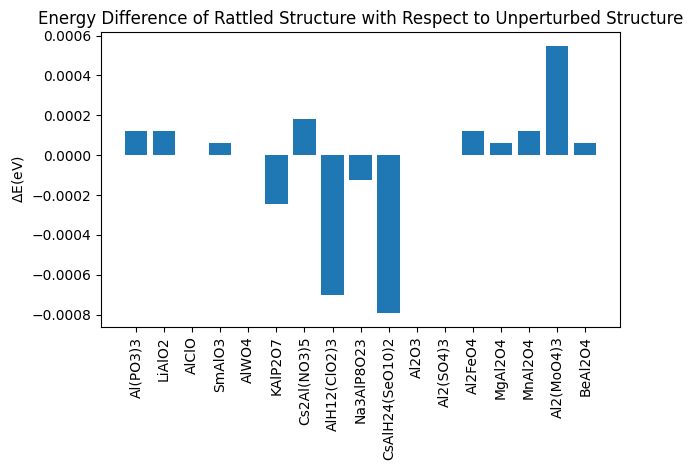

In [27]:
fig, ax = plt.subplots()
bars = ax.bar(compounds, delta_e)  # Assuming you have these lists already

# Add labels on top of each bar
ax.set_title("Energy Difference of Rattled Structure with Respect to Unperturbed Structure")
ax.set_ylabel("$\Delta$E(eV)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"../figures/{MODEL}_energy_difference_plot.png", dpi=300, bbox_inches='tight')

plt.show()